Graficos

In [ ]:
%pip install pandas matplotlib seaborn geopandas fuzzywuzzy python-Levenshtein pywaffle openpyxl xlrd

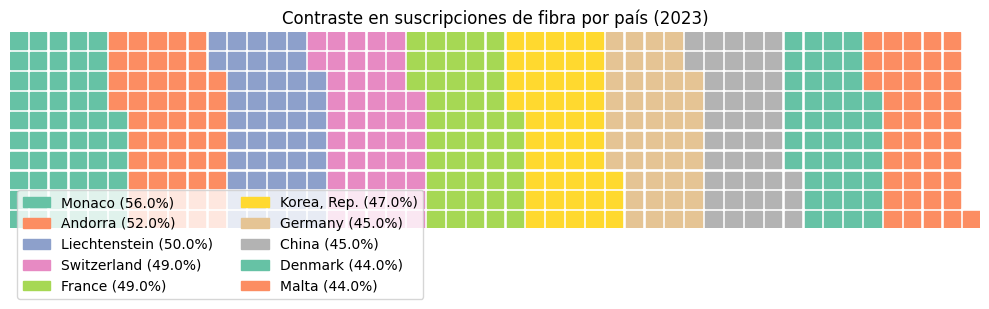

In [1]:
import pandas as pd
from pywaffle import Waffle
import matplotlib.pyplot as plt


file_path = "./Dataset/API_IT.NET.BBND.P2_DS2_en_excel_v2_14959.xlsx"
df = pd.read_excel(file_path, sheet_name="Data", skiprows=3)

df_long = df.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Broadband Subscriptions (%)"
)

df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
df_long = df_long.dropna(subset=["Year", "Broadband Subscriptions (%)"])

df_2023 = df_long[(df_long['Year'] == 2023) & (df_long["Broadband Subscriptions (%)"] > 0)]

top_n = 10
top_countries = df_2023.nlargest(top_n, "Broadband Subscriptions (%)")
waffle_data = top_countries.set_index("Country Name")["Broadband Subscriptions (%)"].round()

# 
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=waffle_data,
    title={'label': 'Contraste en suscripciones de fibra por país (2023)', 'loc': 'center'},
    labels=[f"{k} ({v}%)" for k, v in waffle_data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': 2},
    figsize=(10, 6)
)

plt.show()


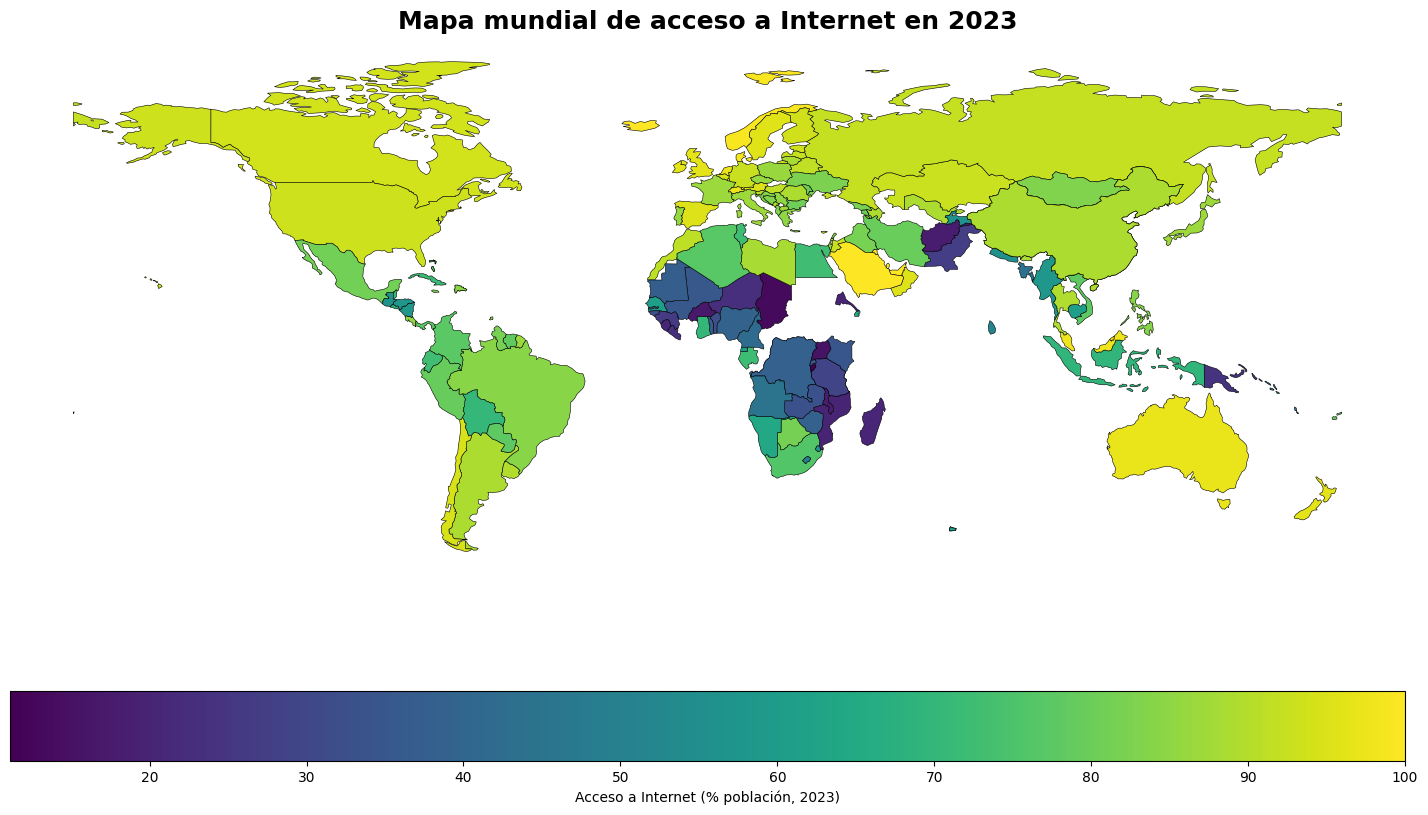

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process

internet_access_data = pd.read_excel('./Dataset/API_IT.NET.USER.ZS_DS2_en_excel_v2_26497.xls', skiprows=3)

internet_access_data.columns = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'] + [str(year) for year in range(1960, 2024)]
internet_access_data_clean = internet_access_data[['Country Name', '2023']].dropna()
internet_access_data_clean.columns = ['Country', 'Access_2023']

shapefile_path = 'geopanda/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

def fuzzy_merge(df_1, df_2, key1, key2, threshold=90):
    s = df_2[key2].tolist()
    matches = df_1[key1].apply(lambda x: process.extractOne(x, s))
    df_1["Best Match"] = matches.apply(lambda x: x[0] if x[1] >= threshold else None)
    return df_1

internet_matched = fuzzy_merge(internet_access_data_clean.copy(), world, 'Country', 'ADMIN', threshold=85)

internet_matched = internet_matched.dropna(subset=['Best Match'])
merged = world.set_index('ADMIN').join(internet_matched.set_index('Best Match'))

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
merged.plot(column='Access_2023', ax=ax, legend=True,
            legend_kwds={'label': "Acceso a Internet (% población, 2023)", 'orientation': "horizontal"},
            cmap='viridis', edgecolor='black', linewidth=0.4)

ax.set_title("Mapa mundial de acceso a Internet en 2023", fontsize=18, weight='bold')
ax.set_axis_off()

plt.show()
